In [42]:
import pandas as pd
import numpy as np
import re
import string
import nltk        
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report 
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix
from sklearn.tree import DecisionTreeClassifier

In [52]:
df = pd.read_csv("consumer_complaints.csv",index_col=0)
df.head()

/var/folders/bl/4hy1jx015313sscgqhkmm6_c0000gn/T/ipykernel_38383/1960908724.py:1: DtypeWarning: Columns (5,11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("consumer_complaints.csv",index_col=0)


,product,sub_product,issue,sub_issue,consumer_complaint_narrative,company_public_response,company,state,zipcode,tags,consumer_consent_provided,submitted_via,date_sent_to_company,company_response_to_consumer,timely_response,consumer_disputed?,complaint_id
date_received,,,,,,,,,,,,,,,,,
08/30/2013,Mortgage,Other mortgage,"Loan modification,collection,foreclosure",NaN,NaN,NaN,U.S. Bancorp,CA,95993,NaN,NaN,Referral,09/03/2013,Closed with explanation,Yes,Yes,511074
08/30/2013,Mortgage,Other mortgage,"Loan servicing, payments, escrow account",NaN,NaN,NaN,Wells Fargo & Company,CA,91104,NaN,NaN,Referral,09/03/2013,Closed with explanation,Yes,Yes,511080
08/30/2013,Credit reporting,NaN,Incorrect information on credit report,Account status,NaN,NaN,Wells Fargo & Company,NY,11764,NaN,NaN,Postal mail,09/18/2013,Closed with explanation,Yes,No,510473
08/30/2013,Student loan,Non-federal student loan,Repaying your loan,Repaying your loan,NaN,NaN,"Navient Solutions, Inc.",MD,21402,NaN,NaN,Email,08/30/2013,Closed with explanation,Yes,Yes,510326
08/30/2013,Debt collection,Credit card,False statements or representation,Attempted to collect wrong amount,NaN,NaN,Resurgent Capital Services L.P.,GA,30106,NaN,NaN,Web,08/30/2013,Closed with explanation,Yes,Yes,511067


In [53]:
state_abbr = [
    'AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA',
    'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME',
    'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM',
    'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX',
    'UT', 'VA', 'VT', 'WA', 'WI', 'WV', 'WY']
df = df[df['state'].isin(state_abbr)]
df = df[df['consumer_complaint_narrative'].notna()]
df

,product,sub_product,issue,sub_issue,consumer_complaint_narrative,company_public_response,company,state,zipcode,tags,consumer_consent_provided,submitted_via,date_sent_to_company,company_response_to_consumer,timely_response,consumer_disputed?,complaint_id
date_received,,,,,,,,,,,,,,,,,
03/19/2015,Debt collection,"Other (i.e. phone, health club, etc.)",Cont'd attempts collect debt not owed,Debt was paid,XXXX has claimed I owe them {$27.00} for XXXX ...,NaN,"Diversified Consultants, Inc.",NY,121XX,Older American,Consent provided,Web,03/19/2015,Closed with explanation,Yes,No,1290516
03/19/2015,Consumer Loan,Vehicle loan,Managing the loan or lease,NaN,Due to inconsistencies in the amount owed that...,NaN,M&T Bank Corporation,VA,221XX,Servicemember,Consent provided,Web,03/19/2015,Closed with explanation,Yes,No,1290492
03/19/2015,Mortgage,Conventional fixed mortgage,"Loan modification,collection,foreclosure",NaN,In XX/XX/XXXX my wages that I earned at my job...,NaN,Wells Fargo & Company,CA,946XX,NaN,Consent provided,Web,03/19/2015,Closed with explanation,Yes,Yes,1290524
03/19/2015,Mortgage,Conventional fixed mortgage,"Loan servicing, payments, escrow account",NaN,I have an open and current mortgage with Chase...,NaN,JPMorgan Chase & Co.,CA,900XX,Older American,Consent provided,Web,03/19/2015,Closed with explanation,Yes,Yes,1290253
03/19/2015,Mortgage,Conventional fixed mortgage,Credit decision / Underwriting,NaN,XXXX was submitted XX/XX/XXXX. At the time I s...,NaN,Rushmore Loan Management Services LLC,CA,956XX,Older American,Consent provided,Web,03/19/2015,Closed with explanation,Yes,Yes,1292137
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
02/10/2016,Credit reporting,NaN,Incorrect information on credit report,Account status,"XXXX XXXX is reporting incorrectly, payments h...",Company chooses not to provide a public response,"TransUnion Intermediate Holdings, Inc.",WA,980XX,NaN,Consent provided,Web,02/10/2016,Closed with explanation,Yes,No,1782682
02/10/2016,Credit reporting,NaN,Incorrect information on credit report,Account status,Reflecting incorrect payment status. Have been...,Company chooses not to provide a public response,"TransUnion Intermediate Holdings, Inc.",WA,980XX,NaN,Consent provided,Web,02/10/2016,Closed with explanation,Yes,No,1781861
02/11/2016,Payday loan,Payday loan,Charged fees or interest I didn't expect,Charged fees or interest I didn't expect,I have been paying {$180.00} a month through d...,NaN,Zarvad III S.A.,NV,891XX,Servicemember,Consent provided,Web,02/11/2016,Closed with explanation,Yes,No,1782804


In [54]:
print('--> There are',df.shape[0],'rows and',df.shape[1],'columns')
print('\n===========================================================\n')
print('--> Missing Values:\n\n',df.isna().sum())
print('\n===========================================================\n')
print('Product Counts:\n\n',df['product'].value_counts())

--> There are 66385 rows and 17 columns


--> Missing Values:

 product                             0
sub_product                     20299
issue                               0
sub_issue                       33634
consumer_complaint_narrative        0
company_public_response         33838
company                             0
state                               0
zipcode                             3
tags                            55090
consumer_consent_provided           0
submitted_via                       0
date_sent_to_company                0
company_response_to_consumer        0
timely_response                     0
consumer_disputed?                  0
complaint_id                        0
dtype: int64


Product Counts:

 Debt collection            17473
Mortgage                   14851
Credit reporting           12435
Credit card                 7864
Bank account or service     5640
Consumer Loan               3664
Student loan                2117
Prepaid card              

In [55]:
data = df[['product', 'issue', 'consumer_complaint_narrative']].dropna().sample(n=10000)

print('Sample dataset:\n\n',df['product'].value_counts()*100/len(df))

Sample dataset:

 Debt collection            26.320705
Mortgage                   22.371018
Credit reporting           18.731641
Credit card                11.846050
Bank account or service     8.495895
Consumer Loan               5.519319
Student loan                3.188973
Prepaid card                1.296980
Payday loan                 1.093621
Money transfers             0.970099
Other financial service     0.165700
Name: product, dtype: float64


In [56]:
nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('english')

def text_clean(text):
    """
    The function performs following tasks:
    1. Lower text
    2. Remove digits
    3. Dropping words with less than 3 character
    4. Remove white space
    5. Remove Stopwords
    """
    clean_words = []
    
    word_list = text.split() #Convert to list
    for word in word_list:
        word_l = word.lower().strip()
        if word_l.isalpha():
            if len(word_l) > 3:
                if word_l not in stopwords :
                    clean_words.append(word_l)
                else:
                    continue
    return clean_words   

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/saitha88/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [63]:
tfidf = TfidfVectorizer(analyzer=text_clean)
x_tfidf = tfidf.fit_transform(data['consumer_complaint_narrative'])


In [64]:
x_tfidf.shape

(10000, 17425)

In [59]:
X_train, X_test, y_train, y_test = train_test_split(x_tfidf, data['product'], test_size=0.2, random_state=42)

In [60]:
rfc = DecisionTreeClassifier(random_state=42)
rfc_model = rfc.fit(X_train,y_train)



In [61]:
prediction = rfc_model.predict(X_test)

In [62]:
print("Confusion Matrix:\n\n",confusion_matrix(y_test,prediction))
print("\n")
print("Classification Report:\n\n",classification_report(y_test,prediction))

Confusion Matrix:

 [[ 78   6  23  14  23   3  12   0   1   6   0]
 [  6  39   6  11  27   2  15   0   4   0   3]
 [ 19  15 145  13  30   3  14   0   2   2   3]
 [  2  12  19 263  60   2  13   1   0   1   3]
 [  8  14  30  53 398   0  21   1   0   2  11]
 [  3   2   1   0   2   2   2   0   0   2   0]
 [ 11  16   9  13  30   0 351   0   3   0   2]
 [  4   2   1   1   0   0   1   0   1   0   0]
 [  1   2   2   0   6   0   6   0   0   1   3]
 [  2   0   4   1   2   1   0   1   0  15   0]
 [  0   3   0   2   9   0  10   0   0   0  31]]


Classification Report:

                          precision    recall  f1-score   support

Bank account or service       0.58      0.47      0.52       166
          Consumer Loan       0.35      0.35      0.35       113
            Credit card       0.60      0.59      0.60       246
       Credit reporting       0.71      0.70      0.70       376
        Debt collection       0.68      0.74      0.71       538
        Money transfers       0.15      0.14

/Users/saitha88/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Text(0.5, 1.0, 'Confusion Matrix')

<Figure size 72000x72000 with 0 Axes>

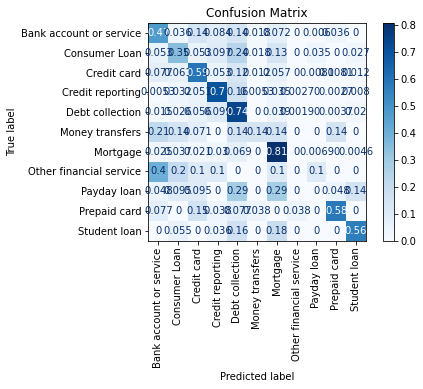

In [72]:
class_names = ['credit_card','credit_reporting','debt_collection','mortgages_and_loans','retail_banking']
plt.figure(figsize=(1000,1000))
plot_confusion_matrix(rfc,X_test,y_test,cmap=plt.cm.Blues,normalize='true')
plt.xticks(rotation=90)
plt.title("Confusion Matrix")